# **Transfer Learning'e / Transfer ile Öğrenmeye** Başlayalım

### Transfer öğrenmesinin ana mantığı şudur:

Yapacağımız modele benzer bir **model başkası tarafından yapılmışsa** o modelin **ağırlıklarını** kendi modelimize **transfer** ederek işimizi görürüz

Hedef modelimizi Colab dosya sistemine indirelim

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-08-16 08:05:27--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 74.125.24.128, 2404:6800:4003:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  41.7MB/s    in 2.0s    

2020-08-16 08:05:29 (41.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Gerekli kütüphaneleri import/ithal edelim

In [2]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

Şimdi hazır bir model yükleyeceğiz

### **ImageNet** tarafından oluşturulmuş **Inception V3** modelini kullanacağız.

Neyse ki bu modeli ithal etmek kolay. **Keras** ile kolayca yapabiliriz.

#### **Inception V3 Nedir ?**

Inception V3 , 48 katman derinliğinde evrişimli bir sinir ağıdır.ImageNet veritabanından bir milyondan fazla görüntü üzerinde eğitilmiştir.Bu model klavye, fare, kalem ve birçok hayvan gibi 1000 nesne kategorisine ayırabilir.

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

Şimdi Inception V3 'ü bir nesneye atayalım ki işlem yapabilelim.

In [4]:
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

**`input_shape`** : Modele vereceğimiz görüntülerin şeklini söyleyen parametre.

**`include_top=False`** : include_top en **üstteki katmanlar** (yani **flatten** ve sonraki **dense** katmanları) için o katmanları alalım mı almayalım mı sorusunu sorar. Hayır dersek almayız ve son katmanları kendimiz tasarlarız.Biz almayacağız çünkü biz yine kedi ve köpek ayırmada kullanacağız.

**`weights=None`** : Modeli dışardan aldık ama istersek o modeldeki ağırlıkların **aynılarını almayabiliriz** ve bunun yerine rastgele ağırlıklardan başlatıp **kendimiz eğitebiliriz**.Bu parametre o işe yarıyor.

In [5]:
pre_trained_model.load_weights(local_weights_file)

**`load_weights`** :Tüm katmanlar için ağırlıkları ya TensorFlowdan ya da seçtiğimizi bir HDF5 dosyasından alır

In [6]:
for layer in pre_trained_model.layers:
  layer.trainable = False

Üstteki kod kutusu ile hazır modelimizdeki katmanların **eğitilebilme durumunu hayır** yaptık. Yani model eğitilirken o katmanlar eğitilmeyecek. Çünkü zaten eğitili.

Modelimize bir bakalım.

In [7]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Gerçekten de devasa bir model.

In [10]:
last_layer = pre_trained_model.get_layer("mixed7")
print("last_layer'ın çıkış şekli/output shape :" ,last_layer.output_shape)
last_output = last_layer.output

last_layer'ın çıkış şekli/output shape : (None, 7, 7, 768)


Şöyle ki biz hazır modelin **mixed7** katmanına kadar almak istedik. Ordan sonraki katman için bize **giriş şekli /input shape** lazım olacağı için hazır modelin son katmanının **çıkış şeklini/output shape** almamız gerek.

**`get_layer`** metodu ile de bir modeldeki katmanın bir objeye nasıl aktarıldığını gördük.

### Şimdi mixed7 katmanından sonra **kendi katmanlarımızı** yazalım

In [15]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024,activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation="sigmoid")(x)
print(x,type(x))

Tensor("dense_7/Sigmoid:0", shape=(None, 1), dtype=float32) <class 'tensorflow.python.framework.ops.Tensor'>


Kendi katmanlarımızı yazdık.Şimdi hazır aldıklarımızı ve kendi oluşturduklarımızı **bir modelde toplayalım.**

**`Model(x,y)`** : Bu fonksiyon katmanları bir objede toplar eğitim ve sonuç özelliklerine göre.

**x=inputs** , **y=outputs**

In [16]:
model = Model(pre_trained_model.input,x)

### Şimdi  modelimizi **derleyelim/compile** edelim

In [27]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

### Tamamdır. Şimdi **cats and dogs** verisetini alalım

In [28]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-08-16 09:05:26--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 2404:6800:4003:c04::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  82.2MB/s    in 0.8s    

2020-08-16 09:05:27 (82.2 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



Gerekli kütüphaneleri import edelim

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

In [30]:
local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [31]:
base_dir = "/tmp/cats_and_dogs_filtered"

train_dir = os.path.join(base_dir,"train")
valid_dir = os.path.join(base_dir,"validation")

train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
valid_cats_dir = os.path.join(valid_dir, 'cats') # Directory with our validation cat pictures
valid_dogs_dir = os.path.join(valid_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

Bu kod satırlarını önceki uygulamalarda yaptığım için şu anda geçiyorum

In [33]:
train_datagen = ImageDataGenerator(rescale=(1.0/255.0),
                                   rotation_range=40,
                                   width_shift_range =0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

valid_datagen = ImageDataGenerator(rescale=(1.0/255.0))

In [35]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=20,
    class_mode="binary",
    target_size=(150,150)
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    batch_size=20,
    class_mode="binary",
    target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [36]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    steps_per_epoch =100,
    epochs=20,
    validation_steps=50,
    verbose=2
)

Epoch 1/20
100/100 - 23s - loss: 0.3136 - accuracy: 0.8770 - val_loss: 0.1135 - val_accuracy: 0.9510
Epoch 2/20
100/100 - 22s - loss: 0.2107 - accuracy: 0.9250 - val_loss: 0.0954 - val_accuracy: 0.9620
Epoch 3/20
100/100 - 22s - loss: 0.2033 - accuracy: 0.9225 - val_loss: 0.1347 - val_accuracy: 0.9550
Epoch 4/20
100/100 - 22s - loss: 0.2068 - accuracy: 0.9295 - val_loss: 0.1906 - val_accuracy: 0.9430
Epoch 5/20
100/100 - 22s - loss: 0.1756 - accuracy: 0.9330 - val_loss: 0.1222 - val_accuracy: 0.9680
Epoch 6/20
100/100 - 22s - loss: 0.1825 - accuracy: 0.9345 - val_loss: 0.1162 - val_accuracy: 0.9600
Epoch 7/20
100/100 - 22s - loss: 0.1461 - accuracy: 0.9500 - val_loss: 0.1226 - val_accuracy: 0.9650
Epoch 8/20
100/100 - 22s - loss: 0.1872 - accuracy: 0.9435 - val_loss: 0.1092 - val_accuracy: 0.9620
Epoch 9/20
100/100 - 22s - loss: 0.1656 - accuracy: 0.9435 - val_loss: 0.1065 - val_accuracy: 0.9630
Epoch 10/20
100/100 - 22s - loss: 0.1560 - accuracy: 0.9425 - val_loss: 0.1069 - val_accura

#### Gördüğünüz gibi skorlar oldukça iyi

Şimdi bir de grafiğe dökelim

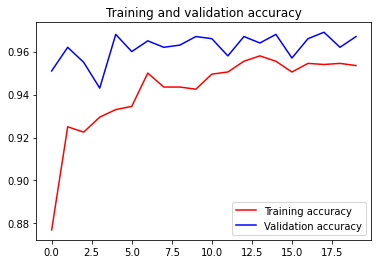

<Figure size 432x288 with 0 Axes>

In [37]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Son